# Tarea 2: ¿Es posible explicar la cantidad de billonarios en base al desarrollo país?  <a class="tocSkip"></a>







En 2006 *Daniel Treisman* publicó un artículo titulado [*Russia Billionaries*](https://pubs.aeaweb.org/doi/pdfplus/10.1257/aer.p20161068) en el cual conectó la cantidad de billonarios de un país con ciertos atributos económicos de los mismos. 

Su conclusión principal fue que Rusia tiene una cantidad de billonarios mayor que la que predicen los indicadores económicos

En esta tarea ustedes analizarán datos macroeconómicos para comprobar o refutar los hallazgos de *D. Treisman*

## Instrucciones generales 

1. Forme un grupo de **máximo tres estudiantes**
1. Versione su trabajo usando un **repositorio privado de github**. Agregue a sus compañeros y a su profesor (usuario github: phuijse) en la pestaña *Settings/Manage access*. No se aceptarán consultas de programación si no se cumple este requisito
1. Su tarea se evaluará en base al último commit antes de la fecha de entrega: **14:10 del Martes 15 de Junio de 2021**. La nota se calcula como ("pt totales" + 1)
1. [Sean leales y honestos](https://www.acm.org/about-acm/code-of-ethics-in-spanish), no copie ni comparta resultados con otros grupos

## Datos

Para esta tarea se les provee de un conjunto de datos `billonarios.csv` indexado por país con los siguientes atributos

- `nbillonarios`: La cantidad de billonarios del pais
- `logpibpc`: El logaritmo del Producto Interno Bruto (PIB) per capita del pais
- `logpob`: El logaritmo de la población del pais
- `gatt`: La cantidad de años que el pais está adherido al *General Agreement on Tariffs and Trade* (GATT)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.stats


## Modelo (1.0pt)

El objetivo principal de esta tarea es entrenar un modelo de regresión que prediga la cantidad de billonarios en función de los demás atributos

> El número de billonarios es una variable entera y no-negativa. 

Un modelo apropiado en este caso es la [regresión de Poisson](https://en.wikipedia.org/wiki/Poisson_distribution), donde definimos la probabilidad condicional para un pais $i$ como  

$$
p(y_i | x_i ) = \frac{\lambda_i^{y_i}}{y_i!} \exp \left ({-\lambda_i} \right)
$$

con intensidad

$$
\lambda_i = \exp \left (\theta_0 + \sum_{j=1}^M \theta_j x_{ij} \right)
$$

donde 

- $\theta$ es el vector de parámetros que deseamos ajustar 
- $y_i$ y $x_i$ son la cantidad de billonarios y el vector de atributos del país $i$, respectivamente

En base a este modelo se pide que ajusten $\theta$ mediante la maximización de la verosimilitud. 

$$
\begin{align}
\hat \theta &= \text{arg}\max_\theta \log \mathcal{L} (\theta) \nonumber \\ 
&= \text{arg}\max_\theta \log \prod_{i=1}^N  p(y_i | x_i) \nonumber \\
&= \text{arg}\max_\theta \sum_{i=1}^N \log p(y_i | x_i) \nonumber
\end{align}
$$

En particular:

1. Estudie y describa la distribución de Poisson en detalle. Muestre como varía la distribución en función de su parámetro $\lambda$, ¿Qué ocurre cuando $\lambda$ es pequeño? ¿Y cuando es grande?
1. Reemplace las expresiones y obtenga una expresión analítica para el logaritmo de la verosimilitud: $\log \mathcal{L}(\theta)$. Muestre la ecuación obtenida. HINT: Puede ignorar los términos que no dependan de $\theta$. Luego obtenga una expresión analítica para la primera derivada del logaritmo de la verosimilitud. Muestra la ecuación obtenida

### Respuesta
1. Es una distribuición probabilística de variable discreta que a partir de una frecuencia de ocurrencia media, determina la probabilidad de que ocurra un determinado número de eventos. Entre sus principales aplicaciones se encuentra el modelado de situaciones donde interesa conocer la frecuencia de un evento en un intervalo de tiempo. El parámetro $\lambda$ representa el número de veces que se espera que ocurra el fenómeno en un intervalo de tiempo. A medida que el valor de $\lambda$ crece, la curva de distrubución de probabilidad tiende a aplanarse, cuando $\lambda$ tiene un valor pequeño la curva será pronunciada, en cambio, si el valor de $\lambda$ es grande, la curva será mucho más aplanada. Como se aprecia en la imagen (Wikipedia).

<div>
<p style = 'text-align:center;'>
<img src="data/poisson.png" alt="JuveYell" width="300px">
</p>
</div>

2. 

Sea $ f_\theta(X_i) = \exp \left (\theta_0 + \sum_{j=1}^M \theta_j x_{ij} \right)$

Reemplazando en la expresión de probabilidad, se obtiene la verosimilitud:

$$
\mathcal{L}(\theta) = \frac{f_\theta(X_i)^{y_i}}{y_i!} \exp \left ({-f_\theta(X_i)} \right)
$$

Luego, calculando el logaritmo de la verosimilitud:

$$
log(\mathcal{L}(\theta)) = ln(\frac{f_\theta(X_i)^{y_i}}{y_i!} \exp \left ({-f_\theta(X_i)} \right))
$$

$$
log(\mathcal{L}(\theta)) = {y_i}{f_\theta(X_i)} - exp(f_\theta(X_i)) - ln({y_i}!) 
$$

Dado que $ln({y_i}!)$ no depende de $\theta$ se puede ignorar. Luego, derivando la expresión obtenemos:

$$
\frac{d(log(\mathcal{L}(\theta)))}{d\theta} = \sum_{j=1}^M x_{ij} {y_i} - \sum_{j=1}^M x_{ij}exp(f_\theta(X_i))
$$

## Implementación (1.5pt)

1. Implemente el logaritmo de la verosimilitud y su derivada usando `numpy`. Utilice operaciones vectoriales (prohibido usar `for` para iterar en los países)
1. Implemente una rutina que encuentre el vector de parámetros óptimo en base a `scipy.optimize.minimize` 
1. Implemente una rutina que calcule el pseudo coeficiente de correlación
$$
R^2 = \frac{\log \mathcal{L} (\hat \theta_0) - \log \mathcal{L} (\hat \theta) }{\log \mathcal{L} (\hat \theta_0)} \in [0, 1]
$$
donde $\log \mathcal{L} (\hat \theta)$ es el logaritmo de la verosimilitud de su mejor modelo y $\log \mathcal{L} (\hat \theta_0)$ es el logaritmo de la verosimilitud de un modelo que tiene sólo el parámetro $\theta_0$
1. Implemente una rutina de bootstrap resampling para encontrar la distribución y los intervalos de confianza empíricos para $\theta$ y el pseudo coeficiente de correlación


### Respuesta

In [2]:
bill_df = pd.read_csv("data/billonarios.csv")
X = bill_df.loc[:,"logpibpc":"gatt"].values
Y = bill_df["nbillonarios"].values

display(bill_df)


pais  nbillonarios   logpibpc     logpob  gatt
0            United States           469  10.786021  19.532846    60
1                   Canada            25  10.743365  17.319439     0
2             Bahamas, The             0  10.072139  12.760934     0
3                    Aruba             0  10.223734  11.526276     0
4                  Bermuda             0  11.446847  11.086334     0
..                     ...           ...        ...        ...   ...
192  Micronesia, Fed. Sts.             0   7.824408  11.556923     0
193                  Samoa             0   8.124372  12.119665    15
194   Hong Kong SAR, China            26  10.356964  15.755374    22
195            Puerto Rico             0  10.122557  15.140160    60
196     West Bank and Gaza             0   7.525887  15.095524     0

[197 rows x 5 columns]

In [3]:
#Características de nuestro dataset
bill_df.describe()

nbillonarios    logpibpc      logpob       gatt
count    197.000000  197.000000  197.000000  197.00000
mean       5.675127    8.560203   15.362351   25.06599
std       34.704232    1.608856    2.223239   22.14103
min        0.000000    5.230423    9.188912    0.00000
25%        0.000000    7.244629   14.106007    1.00000
50%        0.000000    8.485936   15.632252   16.00000
75%        1.000000    9.924738   16.837782   45.00000
max      469.000000   12.175058   21.004417   60.00000

In [4]:
#Correlaciones entre variables
bill_df.corr()

nbillonarios  logpibpc    logpob      gatt
nbillonarios      1.000000  0.160574  0.244472  0.179087
logpibpc          0.160574  1.000000 -0.235871  0.195274
logpob            0.244472 -0.235871  1.000000  0.296799
gatt              0.179087  0.195274  0.296799  1.000000

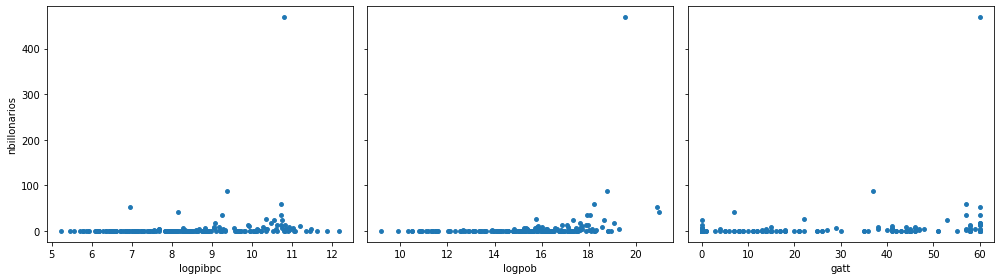

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4), tight_layout=True, sharey=True)
for i, col in enumerate(bill_df.columns[2:]):
    ax[i].scatter(bill_df[col], bill_df["nbillonarios"], s=15)
    ax[i].set_xlabel(col)
ax[0].set_ylabel(bill_df.columns[1]);

### Observaciones previas

Previo a obtener el vector de parametros óptimo de nuestros datos es necesario indagar en como se comportan nuestros parametros con respecto a la variable objetivo. En base a esto pudimos rescatar ciertas observaciones: 

- A simple vista no existe una correlación fuerte de las variables logpibpc, logpob, gatt con respecto a la cantidad de billonarios por país obteniendo 
    - logpibpc: Correlación de **0,1605**
    - logpob: Correlación de **0,244**
    - gatt: Correlación de **0,179**

- De los gráficos divididos en cada variable con respecto a la cantidad de billonarios: 
    - **logpibpc:** Los paises que se encuentran en la media del PIB per cápita presentan mayor cantidad de billonarios (a excepción de Estados Unidos). 
    - **logpob:** Los paises que tienen una mayor población son los que presentan mayor cantidad de billonarios. 
    - **gatt:** Podría decirse que los paises que han estado más tiempo adheridos al GATT tienen una mayor cantidad de billonarios. 
    

- A priori podemos decir que los datos se encuentran en concordancia con lo esperado; en otras palabras, podríamos obtener buenos resultados con respecto a las predicciones posteriores acerca de nuestro modelo de estudio. 

In [6]:
#Estandarización
#Descomenta esta linea para ver los cambios


X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

1. Implementación del logaritmo de la verosimilitud y su derivada.

In [7]:
# Modelo de Poisson
def poisson(theta, X):
    f = theta[0] + np.sum(theta[1:]*X, axis=1)     
    return np.exp(f)

# Logaritmo de verosimilitud (función de costo)
def log_verosimilitud(theta, *args):
    X, Y = args
    lambd = poisson(theta, X)
    # Se agrega signo negativo ya que se busca minimizar
    return -np.sum(Y*(theta[0] + np.sum(theta[1:]*X, axis=1)) - lambd, axis=0)
    
    
# Derivada de la función de costo
def derivada_logvs(theta, *args):
    X, Y = args
    N = len(Y)
    lambd = poisson(theta, X)
    X1 = np.concatenate((np.ones(shape=(N, 1)), X), axis=1)
    a = Y - lambd
    return -np.sum(a[:,np.newaxis]*X1, axis=0)

2. Implementación de rutina que encuentra el vector de parámetros óptimo.

In [8]:
# Solución inicial
D = X.shape[1]
theta_init = np.zeros(D+1)

best_theta = np.zeros_like(theta_init)

# Mejor valor de theta
res = scipy.optimize.minimize(fun=log_verosimilitud, # Función de costo
                              x0=theta_init, # Valor inicial de theta
                              method='BFGS', # Método de optimización
                              jac=derivada_logvs, # Derivada de la función de costo
                              args=(X, Y), # Datos
                              tol=1e-1)
display(res)


      fun: -3459.0919420028813
 hess_inv: array([[ 0.01098832, -0.00322666, -0.00458765, -0.0001201 ],
       [-0.00322666,  0.00297432,  0.00102798, -0.0011876 ],
       [-0.00458765,  0.00102798,  0.00258946, -0.00031231],
       [-0.0001201 , -0.0011876 , -0.00031231,  0.00167688]])
      jac: array([-0.01067391, -0.01342889, -0.01354998, -0.0103781 ])
  message: 'Optimization terminated successfully.'
     nfev: 16
      nit: 13
     njev: 16
   status: 0
  success: True
        x: array([-1.62705614,  1.73932846,  2.5976039 ,  0.13180185])

3. Implementación de rutina de bootstrap resampling para encontrar la distribución y los intervalos de confianza empíricos para $\theta$ y el pseudo coeficiente de correlación.

In [9]:
# Modelo de Poisson modificado con theta[0] como unico parámetro
def modif_poisson(theta):   
    return np.exp(theta)

# Logaritmo de verosimilitud modificado
def modif_log_verosimilitud(theta, *args):
    X, Y = args
    lambd = modif_poisson(theta)
    # Se agrega signo negativo ya que se busca minimizar
    return np.sum(Y*(theta) - lambd, axis=0)

# Logaritmo del facotrial de y
def log_yfact(y):
    final = 0
    for i in range(len(y)):
        if y[i] != 0:
            c = np.linspace(1, y[i], y[i])
            final += np.sum(np.log(c))

    return final



In [10]:
# Pseudo coeficiente de correlación
def pseudo_coef(theta_best, X, Y):
    R2 = (modif_log_verosimilitud(theta_best[0], X, Y) - (-log_verosimilitud(theta_best, X, Y)))/(modif_log_verosimilitud(theta_best[0], X, Y)-log_yfact(Y))
    return R2


print("\nPseudo Coeficiente de correlación")
display(pseudo_coef(res.x,X,Y))



Pseudo Coeficiente de correlación


0.9238036711713494

In [11]:
#bootstrap resampling
def resampling(x, y):
    size = len(x)
    idx = np.random.choice(size, size=size, replace=True)
    return x[idx], y[idx]

def boostrap_poisson(x, y, T):
    #params = pd.DataFrame(columns=['best_theta'], index=np.arange(T))
    params = np.zeros(shape=(T, 4))
    for t in range(T):
        res_boostrap = scipy.optimize.minimize(fun=log_verosimilitud, # Función de costo
                              x0=theta_init, # Valor inicial de theta
                              method='BFGS', # Método de optimización
                              jac=derivada_logvs, # Derivada de la función de costo
                              args=(resampling(X, Y)), # Datos
                              tol=1e-1)
        params[t, :] = [i for i in res_boostrap.x]
    return params

boostrap_params = boostrap_poisson(X, Y, T=1000)

print("\nResultados del Boostrap")
display(boostrap_params)




Resultados del Boostrap


array([[-1.20506565,  1.78999648,  2.34363937,  0.12250719],
       [-1.19571019,  1.61772749,  2.32983611,  0.22658725],
       [-2.55576066,  1.83585537,  3.08529082,  0.14139396],
       ...,
       [-1.0682978 ,  1.54190564,  2.25528743,  0.01435651],
       [-0.9683326 ,  1.43186294,  2.16076773,  0.13517728],
       [-0.80045384,  1.46934974,  2.01468204,  0.04821576]])

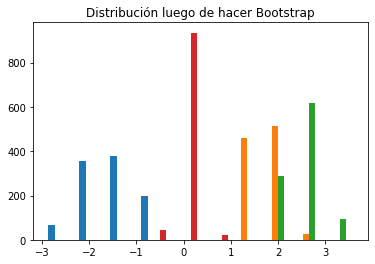

In [13]:
import matplotlib.pyplot as plt

# plot scores
plt.hist(boostrap_params)
plt.title("Distribución luego de hacer Bootstrap")
plt.show()

In [14]:
#Intervalo de confianza 
IC = np.percentile(boostrap_params, [2.5, 97.5])
print("Intervalo de confianza al 95%: {}".format(IC))

Intervalo de confianza al 95%: [-2.14255023  2.97828808]


In [20]:
#Media de los valores de cada parametro obtenidos en bootstrap
def get_mean(idx):
    return boostrap_params[:, idx].mean()

mean_bootstrap = [get_mean(idx) for idx in range(4)]
display(mean_bootstrap)


[-1.482082791714882,
 1.698024210271065,
 2.5318166487908176,
 0.023669822434349747]

In [18]:
# Intervalo de confianza

def Intervalo(Valor_X):
    r_bootstrap = boostrap_params[:, 0]
    params = scipy.stats.linregress(Valor_X, Y)
    #fig, ax = plt.subplots(figsize=(7, 6), tight_layout=True)
    media=r_bootstrap.mean()
    #for i in range(len(r_bootstrap)):
    #    ax.hist(r_bootstrap[i], bins=20, density=True, color = "skyblue")

    #hist_val, hist_lim, _ = ax.hist(media, bins=20, density=True, color = "skyblue")
    #ax.plot([params.rvalue]*2, [0, np.max(hist_val)], 'r-', lw=2)
    IC = np.percentile(media, [2.5, 97.5])
    #ax.plot([IC[0]]*2, [0, np.max(hist_val)], 'k--', lw=2)
    #ax.plot([IC[1]]*2, [0, np.max(hist_val)], 'k--', lw=2)
    print(f"Intervalo de confianza al 95% de los parámetros: {IC}")
    print(media)
    #display(pseudo_coef(media,X,Y))



In [19]:
X1 = bill_df.loc[:,"logpibpc"].values
X2 = bill_df.loc[:,"gatt"].values
X3 = bill_df.loc[:,"logpob"].values
Intervalo(X3)


Intervalo de confianza al 95% de los parámetros: [-1.48208279 -1.48208279]
-1.482082791714882


## Resultados (3pt)

1. Compare los métodos `CG`, `BFGS`, `Nelder-mead` y `Powell` en términos del vector de parámetros obtenido, la log verosimilitud alcanzada, el pseudo coeficiente de correlación alcanzado, el número de iteraciones necesarias para converger y el tiempo total para converger. Seleccione uno de los métodos para contestar los siguientes puntos
1. Muestre las distribuciones empíricas de los parámetros y del pseudo coeficiente de correlación. ¿Cuáles parámetros tienen $\theta$ significativamente distinto de cero? ¿Cuál es el intervalo de confianza al 95% del $R^2$? En base a esto ¿Qué puede decir sobre su modelo?
1. Prediga la cantidad de billonarios de cada país usando su modelo. Gráfique el error entre la cantidad de billonarios predicha y la cantidad de billonarios real. El gráfico debe mostrar los paises ordenados de mayor a menor **error absoluto**.  Analice ¿Cuáles son los 5 países con mayor error en la predicción? ¿Cuáles países tienen un exceso de billonarios? ¿Cúales paises tienen menos billonarios de lo esperado? ¿Qué puede decir sobre Rusia?



## 1 .-

Previo a la comparación de todos los métodos calcularemos el tiempo total en el que convergen estos (CG, BFGS, Nelder-mead, Powell). Sin embargo, debido a que usaremos una de las magias de Python `timeit`, debemos ejecutarlas en bloques separados para que esta no nos arroje un error. 

- **Método CG**

In [21]:
%%timeit
res = scipy.optimize.minimize(fun=log_verosimilitud, # Función de costo
                              x0=theta_init, # Valor inicial de theta
                              method='CG', # Método de optimización
                              jac=derivada_logvs, # Derivada de la función de costo
                              args=(X, Y), # Datos
                              tol=1e-1)

5.87 ms ± 212 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


- **Método BFGS**

In [22]:
%%timeit
res = scipy.optimize.minimize(fun=log_verosimilitud, # Función de costo
                              x0=theta_init, # Valor inicial de theta
                              method='BFGS', # Método de optimización
                              jac=derivada_logvs, # Derivada de la función de costo
                              args=(X, Y), # Datos
                              tol=1e-1)

2.94 ms ± 177 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


- **Método Nelder-mead**

In [23]:
%%timeit
res = scipy.optimize.minimize(fun=log_verosimilitud, # Función de costo
                              x0=theta_init, # Valor inicial de theta
                              method='Nelder-mead', # Método de optimización
                              jac=derivada_logvs, # Derivada de la función de costo
                              args=(X, Y), # Datos
                              tol=1e-1)

C:\Users\rszh9\anaconda3\lib\site-packages\scipy\optimize\_minimize.py:517: RuntimeWarning: Method Nelder-mead does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,


7.67 ms ± 127 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


- **Método Powell**

In [24]:
%%timeit
res = scipy.optimize.minimize(fun=log_verosimilitud, # Función de costo
                              x0=theta_init, # Valor inicial de theta
                              method='Powell', # Método de optimización
                              jac=derivada_logvs, # Derivada de la función de costo
                              args=(X, Y), # Datos
                              tol=1e-1)

C:\Users\rszh9\anaconda3\lib\site-packages\scipy\optimize\_minimize.py:517: RuntimeWarning: Method Powell does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,


2.44 ms ± 111 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [25]:
#Comparación métodos de entrenamiento 

def show_results(params_vec):
    print("Vector de parámetros: {}".format(params_vec.x))
    print("Éxito del test: {}".format(params_vec.success))
    print("Mensaje: {}".format(params_vec.message))
    print("Número de evaluaciones: {}".format(params_vec.nfev))
    print("Número de iteraciones: {}".format(params_vec.nit))
    print("Log verosimilitud: {}".format(log_verosimilitud(params_vec.x, X, Y)))
    print("Pseudo coeficiente de relación: {}".format(pseudo_coef(params_vec.x, X, Y)))

def run_test(method):
    res = scipy.optimize.minimize(fun=log_verosimilitud, # Función de costo
                              x0=theta_init, # Valor inicial de theta
                              method=method, # Método de optimización
                              jac=derivada_logvs, # Derivada de la función de costo
                              args=(X, Y), # Datos
                              tol=1e-1)
    return res




print("****** RESULTADOS DE CADA MÉTODO *******")
#Método CG
print("\nMétodo CG")
show_results(run_test('CG'))

#Método BFGS
print("\nMétodo BFGS")
show_results(run_test('BFGS'))
#Nelder-mead
print("\nMétodo Nelder-mead")
show_results(run_test('Nelder-mead'))

#Powell
print("\nMétodo Powell")
show_results(run_test('Powell'))



****** RESULTADOS DE CADA MÉTODO *******

Método CG
Vector de parámetros: [-1.62731549  1.73954583  2.59770711  0.1317069 ]
Éxito del test: True
Mensaje: Optimization terminated successfully.
Número de evaluaciones: 41
Número de iteraciones: 20
Log verosimilitud: -3459.0919349576675
Pseudo coeficiente de relación: 0.9238073755784523

Método BFGS
Vector de parámetros: [-1.62705614  1.73932846  2.5976039   0.13180185]
Éxito del test: True
Mensaje: Optimization terminated successfully.
Número de evaluaciones: 16
Número de iteraciones: 13
Log verosimilitud: -3459.0919420028818
Pseudo coeficiente de relación: 0.9238036711713496

Método Nelder-mead
Vector de parámetros: [0.15623293 1.50620906 1.55837078 0.10127996]
Éxito del test: True
Mensaje: Optimization terminated successfully.
Número de evaluaciones: 116
Número de iteraciones: 66
Log verosimilitud: -3198.704678686437
Pseudo coeficiente de relación: 0.8232030627863448

Método Powell
Vector de parámetros: [0.38196603 1.381966   1.381966  

## 2 .-

In [26]:
#Distribuciones empiricas de los parametros y pseudo coeficiente 
#Intervalo(X1)
display(res.x)
display(pseudo_coef(res.x,X,Y))

array([-1.62705614,  1.73932846,  2.5976039 ,  0.13180185])

0.9238036711713496


Los parámetros que tienen 𝜃 destintos de cero para el obtenido a traves de vector de parámetros óptimos son:

$$ -1.62705614 , 1.73932846 , 2.5976039 $$

Intervalo de confianza al 95% de r: 
$$ [-2.13984588 , 3.00701635] $$
Esto significa que tenemos un 95% de confianza que los valores que obtendremos de 𝜃 estarán entre esos dos valores, que para nuestro caso a traves de los 𝜃 obtenidos se puede encontrar que efectivamente casi todos los parametros encontrados están entre esos intervalos a excepción de algunos que se escapan en poca medida, pero están dentro del error tolerable. Para nuestro modelo de predicción esto significa que se esta haciendo un buen trabajo y que el error que se obtendra al final será el minimo deseable.

## 3 .-

Para la predicción se optó por el método BFGS, basado en su tiempo de ejecución reducido y a la calidad de su solución.

In [27]:
# Entrenamiento
res = run_test('BFGS')

In [28]:
# Predicción de los datos
theta = res.x
y_pred = poisson(theta, X)

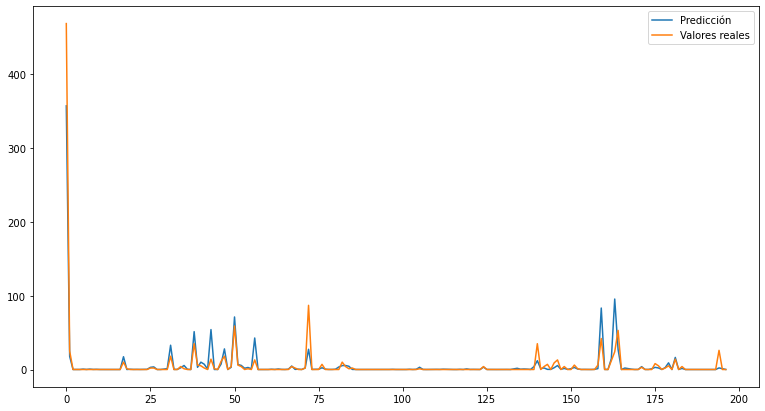

In [29]:
# Gráfica de predicción versus valores reales
x = (np.arange(0,197,1))
fig, ax = plt.subplots(figsize=(13,7))
ax.plot(x,y_pred, label='Predicción')
ax.plot(x,Y, label='Valores reales')
ax.legend()

Se observa a primera impresión que en general para los países que tienen una cantidad relativamente baja de millonarios el modelo da una buena predicción. Sin embargo, en los países con una mayor cantidad de millonarios el modelo tiende a dar predicciones más erráticas, probablemente porque tienen comportamientos atípicos en base a sus datos socioeconómicos

In [30]:
# Cálculo del error absoluto
err_abs = (np.abs(Y - y_pred))
err_real = (Y - y_pred)

Como estrategia para no perder el índice de los países luego de ordernarlos según su error absoluto, se creó un DataFrame con tres columnas, el error absoluto, el error real y el índice, y luego se ordenó con pandas.DataFrame.sort_values

In [31]:
# Array correspondiente a los índices de los países
x = (np.arange(0,197,1))

# Creación del DataFrame
err_df = pd.DataFrame(data={'err_abs': err_abs, 'err_real': err_real, 'id':x})

# Ordenamiento descendente del error absoluto
err_df.sort_values(by=['err_abs'], ascending=False, inplace=True)

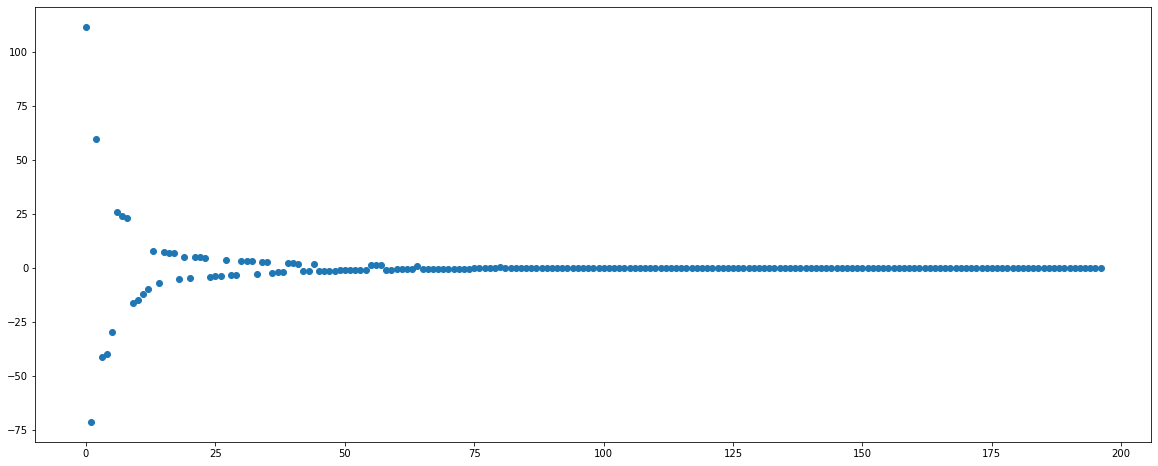

In [38]:
# Gráfica de error de predicción con los países ordenados descendentemente según error absoluto
fig, ax = plt.subplots(figsize=(20,8))
x = (np.arange(0,197,1))
y = err_df['err_abs']
ax.scatter(x, err_df['err_real'])

Se observa que hay unos cinco países que tienen un error real considerable, en especial el país que presenta un error mayor a 100. A partir de esos cinco países, el error puede considerarse despreciable. En general, se observa que la mayoría de países tienen un error muy bajo.

In [32]:
# Obtención de los 5 países con mayor error absoluto
top5 = err_df.iloc[0:5].values[:,2]

In [33]:
# Información socioeconómica de los países en el top 5
bill_df.iloc[top5]

pais  nbillonarios   logpibpc     logpob  gatt
0         United States           469  10.786021  19.532846    60
163               Japan            24  10.544774  18.665226    53
72   Russian Federation            87   9.366808  18.771030    37
159               China            42   8.143926  21.004417     7
43               France            14  10.722429  17.980175    60

In [34]:
# Error absoluto y real de los países en el top 5
err_df.iloc[0:5]

err_abs    err_real   id
0    111.529887  111.529887    0
163   71.535834  -71.535834  163
72    59.581743   59.581743   72
159   41.333968  -41.333968  159
43    40.129805  -40.129805   43

Los cinco países con mayor error absoluto en la predicción de nuestro modelo son: Estados Unidos, Japón, Rusia, Francia y China.

In [35]:
# Lista de países con error real negativo
err2_df = err_df.sort_values(by=['err_real'])
id1 = err2_df['id'].values[0:169]
bill_df['pais'].values[id1]

array(['Japan', 'China', 'France', 'Italy', 'United Kingdom', 'Brazil',
       'Germany', 'Spain', 'Mexico', 'Belgium', 'Netherlands',
       'Argentina', 'Indonesia', 'Iran, Islamic Rep.', 'Finland',
       'Denmark', 'Korea, Rep.', 'Australia', 'Nigeria', 'Pakistan',
       'Czech Republic', 'Hungary', 'Algeria', 'Austria', 'Venezuela, RB',
       'Norway', 'Iraq', 'Peru', 'Bangladesh', 'Qatar', 'Puerto Rico',
       'Vietnam', 'Slovak Republic', 'Colombia', 'Thailand', 'Morocco',
       'Angola', 'Poland', 'Croatia', 'Libya', 'Greece', 'Philippines',
       'Ecuador', 'Dominican Republic', 'Cuba', 'Belarus', 'Sudan',
       'Luxembourg', 'Bulgaria', 'Sri Lanka', 'Slovenia', 'Kenya',
       'Tunisia', 'Azerbaijan', 'Serbia', 'Lithuania', 'Guatemala',
       'Ghana', 'Uruguay', 'Cameroon', 'Latvia', 'Yemen, Rep.',
       'Ethiopia', 'Panama', 'Tanzania', 'Trinidad and Tobago',
       'Uzbekistan', 'Costa Rica', "Cote d'Ivoire", 'Congo, Dem. Rep.',
       'Bahrain', 'El Salvador', 'Jor

El error real negativo puede interpretarse como países donde de acuerdo al modelo hay menos billonarios de los que debería de acuerdo a sus datos socioeconómicos.

In [36]:
# Lista de países con error real positivo
id2 = err2_df['id'].values[169:,]
bill_df['pais'].values[id2]

array(['Oman', 'South Africa', 'Monaco', 'Portugal', 'Belize', 'Chile',
       'Cyprus', 'Iceland', 'Egypt, Arab Rep.', 'New Zealand', 'Kuwait',
       'Singapore', 'Ireland', 'United Arab Emirates', 'Switzerland',
       'Ukraine', 'Sweden', 'Kazakhstan', 'Malaysia', 'Israel', 'Lebanon',
       'Canada', 'Saudi Arabia', 'Turkey', 'Hong Kong SAR, China',
       'India', 'Russian Federation', 'United States'], dtype=object)

Por otro lado, el error real positivo corresponde a países que según el modelo tienen un exceso de billonarios.

En el caso de los cinco países con mayor error absoluto, Estados Unidos tiene tiene el mayor error real con un exceso de billonarios de 111, lo que significa que de acuerdo a sus datos socioeconómicos tiene una cantidad muy atípica de billinarios. Esto podría explicarse por su modelo ecónomico capitalista que tiende a foverecer a los más acaudalados. En el segundo lugar se encuentra Japón, pero esta vez presenta una cantidad inferior de billonarios de la que debería. Al igual que Estados Unidos, Japon es una potencia mundial, sin embargo, tiene modelo ecnómico económico bastante diferente, lo que puede explicar estos resultados. En el caso de Rusia, al igual que Estados Unidos tiene un exceso de billonarios, por lo que se podría en base a la similitud de sus datos socioeconómicos que tiene un modelo ecnómico similar al de Estados Unidos.

## Conclusiones (0.5pt)

Resuma sus principales hallazgos y comente sobre las desafios encontrados al desarrollar esta tarea 

En general el modelo si es capaz de predecir razonablemente la cantidad de billonarios de la mayoría de países, a excepción de algunos pocos casos atípicos. Es posible notar ciertos patrones, por ejemplo en base al modelo ecónomico que siguen los países, sin embargo, es problable que se requieran algunas otras variables para que las estimaciones sean más consistentes, ya que la cantidad de billonarios de un país puede depender de muchos otros factores, como por ejemplo la calidad de vida. Si bien las predicciones no son perfectas, es remarcable lo que se puede lograr con estas herramientas y el alcance que puede tener en el estudio de muchas otras áreas.